# De novo design

### Developers: Mat Bieniek, Ben Cree, Rachael Pirie, Josh Horton

* Add R-groups in user-defined positions
* Output ADMET properties
* Perform constrained optimisation
* Score poses
* Send output to free energy calculations

Open source, customisable, fast/easy to use.

In [1]:
import copy
import glob
import prody
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd
from rgroup import RMol, RList, build_molecules, fix_receptor, optimise_in_receptor, RGroups, sort_conformers, ic50

<frozen importlib._bootstrap>:228: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.


In [2]:
%cd /home/c0065492/rgroups/temp/rgroups_git/data/cdk2_dat/

/home/c0065492/rgroups/temp/rgroups_git/data/cdk2_dat


In [3]:
prefix = 'lig_' #to extract experimental data from ligands.yml

In [4]:
!wget -nc https://files.rcsb.org/download/1H1Q.pdb
pdb = '1H1Q.pdb'

File ‘1H1Q.pdb’ already there; not retrieving.



In [5]:
RMol.set_gnina(loc='/home/c0065492/software/gnina')

In [6]:
# load the complex with the ligand
sys = prody.parsePDB(pdb)
#sys = prody.parsePDB('jnk1/2gmx.pdb')

rec = sys.select('not (nucleic or hetatm) and not water')
#mol = sys.select('resname 19H and chain A')
mol = sys.select('resname 0X5')

prody.writePDB('rec.pdb', rec)
#prody.writePDB('lig.pdb', mol)

@> 9325 atoms and 1 coordinate set(s) were parsed in 0.08s.


'rec.pdb'

In [7]:
#!wget 'https://models.rcsb.org/v1/5nev/ligand?auth_seq_id=301&label_asym_id=E&encoding=sdf&filename=5nev_E_72L.sdf' -O lig.sdf
#!obabel jnk1/core.sdf -O jnk1/coreh.sdf -p 7
!obabel -isdf core.sdf -osdf -O coreh.sdf -p 7
# ^manually modify the files if need be
%pwd

*** Open Babel Warning  in ReadMolecule
  Failed to kekulize aromatic bonds in MOL file (title is 1h1q)

1 molecule converted


'/home/c0065492/rgroups/temp/rgroups_git/data/cdk2_dat'

In [8]:
# load the ligand
# rdkit doesn't do a good job with protonation, 
#init_mol = Chem.MolFromPDBFile('lig.pdb', removeHs=False)
#init_mol = Chem.AddHs(init_mol, addCoords=True)

init_mol = Chem.SDMolSupplier('coreh.sdf', removeHs=False)[0]

# get the R group representation of the rdkit Mol
rinit_mol = RMol(init_mol)

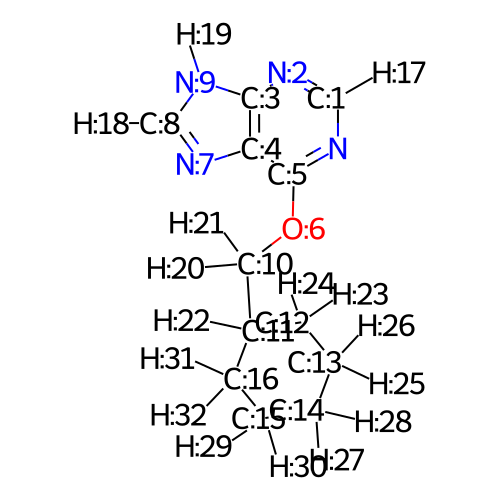

In [9]:
###### select the atom to be replaced with the R group
rinit_mol.rep2D(idx=True, size=(500, 500))

In [10]:
#remove 44 since all conformers clash with protein
ligand_ids = ['17', '1h1q', '1h1r', '1h1s', '1oi9', '1oiu', '1oiy', '20', '21', '22', '26', '28', '29', '30', '31', '32']

In [11]:
#ligand_ids = ['13c', '13d', '13h', '17c', '17h']
# read the rgroups 1 by 1 in a loop
#ligand_idss that there is only one -r.mol in each dir
rgroups = [Chem.MolFromMolFile(glob.glob(f'{ligand_id}/*.mol')[0], removeHs=False) for ligand_id in ligand_ids]
rgroups

In [12]:
# build a list of molecules
attachment_index = [17]
rmols = build_molecules(rinit_mol, attachment_index, rgroups)

Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7faeeb476e20> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7faeeb476e80>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7faeeb3385e0> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7faeeb338be0>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7faeeb4ecee0> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7faeeb338400>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7faeeb3385e0> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7faeeb338be0>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7faeeb4ecee0> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7faeeb338400>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7faeeb3385e0> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7faeeb338be0>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7faeeb4ecee0> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7faeeb338400>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom o

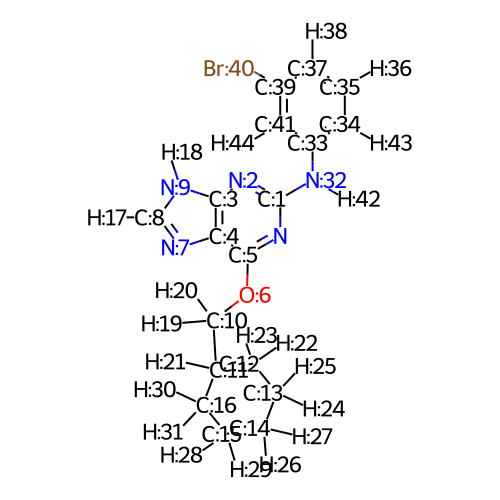

In [13]:
rmols[0].rep2D(idx=True, size=(500, 500))

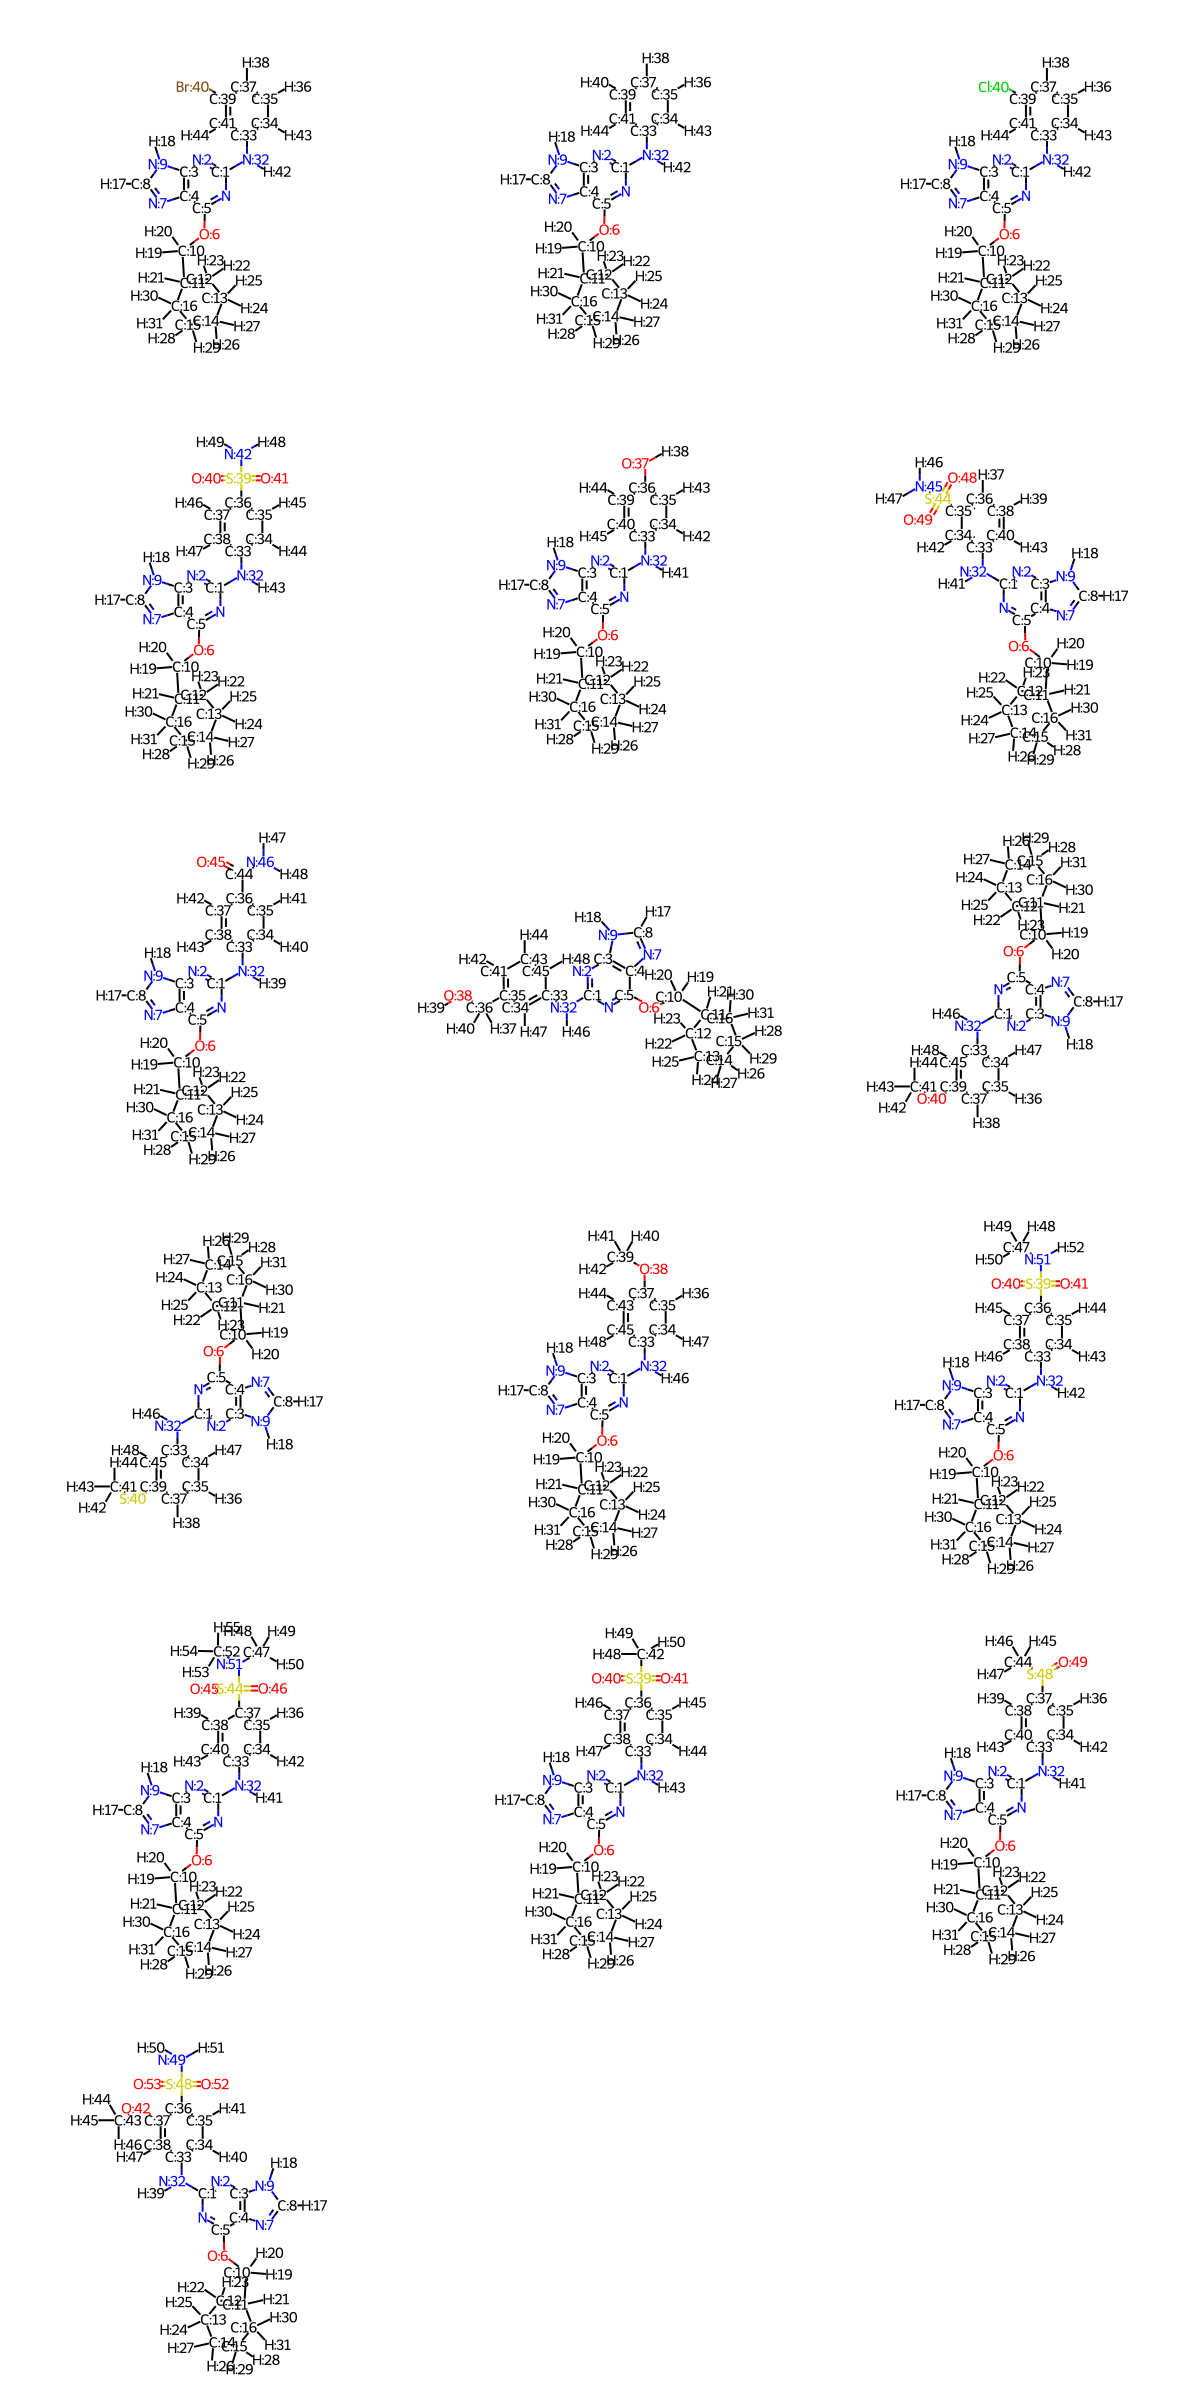

In [14]:
rmols.rep2D()

In [15]:
rmols[3].rep3D()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [16]:
rmols.toxicity()

MW  HBA  HBD    LogP  Pass_Ro5  has_pains  has_unwanted_subs  \
0  401.085122    5    2  4.8181      True      False              False   
0  323.174610    5    2  4.0556      True      False              False   
0  357.135638    5    2  4.7090      True      False              False   
0  402.147410    7    3  2.7030      True      False              False   
0  339.169525    6    3  3.7612      True      False               True   
0  402.147410    7    3  2.7030      True      False              False   
0  366.180424    6    3  3.1545      True      False              False   
0  353.185175    6    3  3.5479      True      False              False   
0  353.185175    6    2  4.0642      True      False              False   
0  369.162331    6    2  4.7775      True      False              False   
0  353.185175    6    2  4.0642      True      False              False   
0  416.163060    7    3  2.9637      True      False              False   
0  430.178710    7    2  3.3059      True      False              False   
0  401.152161    7    2  3.4591      True      False              False   
0  385.157246    6    2  3.7930      True      False              False   
0  432.157974    8    3  2.7116      True      False              False   

   has_prob_fgs  synthetic_accessibility  
0         False                 7.888204  
0         False                 5.300357  
0         False                 7.871124  
0         False                 7.975242  
0         False                 4.574418  
0         False                 7.975242  
0         False                 2.958730  
0         False                 6.503735  
0         False                 6.144321  
0         False                 6.341304  
0         False                 6.144321  
0         False                 6.148474  
0         False                 6.871536  
0         False                 5.266285  
0         False                 7.492887  
0         False                 5.599082

In [17]:
rmols.generate_conformers(num_conf=200,
                         minimum_conf_rms=0.5,
                         )

RMol index 0
removed 192 duplicated conformations
RMol index 1
removed 192 duplicated conformations
RMol index 2
removed 192 duplicated conformations
RMol index 3
removed 156 duplicated conformations
RMol index 4
removed 191 duplicated conformations
RMol index 5
removed 163 duplicated conformations
RMol index 6
removed 184 duplicated conformations
RMol index 7
removed 185 duplicated conformations
RMol index 8
removed 185 duplicated conformations
RMol index 9
removed 185 duplicated conformations
RMol index 10
removed 184 duplicated conformations
RMol index 11
removed 125 duplicated conformations
RMol index 12
removed 62 duplicated conformations
RMol index 13
removed 171 duplicated conformations
RMol index 14
removed 170 duplicated conformations
RMol index 15
removed 133 duplicated conformations


In [18]:
#rmol.rep3D(template=True)

In [19]:
rmols.GetNumConformers()

[9, 9, 9, 45, 10, 38, 17, 16, 16, 16, 17, 76, 139, 30, 31, 68]

### Optimise conformers in context of protein

In [20]:
# fix the receptor file 
fix_receptor("rec.pdb", "rec_h.pdb")
# load back into prody
rec_fix = prody.parsePDB("rec_h.pdb")

@> 17992 atoms and 1 coordinate set(s) were parsed in 0.11s.


In [21]:
# filter by the protein clashes
rmols[2].rep3D(prody=rec_fix)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [22]:
rmols.removeConfsClashingWithProdyProt(rec_fix)

RMol index 0
Clash with the protein. Removing conformer id: 8
Clash with the protein. Removing conformer id: 5
Clash with the protein. Removing conformer id: 4
Clash with the protein. Removing conformer id: 3
Clash with the protein. Removing conformer id: 2
Clash with the protein. Removing conformer id: 1
Clash with the protein. Removing conformer id: 0
RMol index 1
Clash with the protein. Removing conformer id: 8
Clash with the protein. Removing conformer id: 6
Clash with the protein. Removing conformer id: 4
Clash with the protein. Removing conformer id: 3
Clash with the protein. Removing conformer id: 2
Clash with the protein. Removing conformer id: 1
Clash with the protein. Removing conformer id: 0
RMol index 2
Clash with the protein. Removing conformer id: 8
Clash with the protein. Removing conformer id: 7
Clash with the protein. Removing conformer id: 5
Clash with the protein. Removing conformer id: 4
Clash with the protein. Removing conformer id: 2
Clash with the protein. Removi

In [23]:
rmols.GetNumConformers()

[2, 2, 2, 0, 0, 8, 0, 4, 3, 2, 0, 0, 0, 0, 0, 1]

In [24]:
rmols[2].rep3D(prody=rec_fix)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [25]:
# opt_mol, energies 
energies = rmols.optimise_in_receptor(
    receptor_file="rec_h.pdb", 
    ligand_force_field="openff", 
    use_ani=True,
    sigma_scale_factor=0.8,
    relative_permittivity=4
)

RMol index 0


Optimising conformer: 100%|███████████████████████| 2/2 [00:53<00:00, 26.77s/it]


RMol index 1
using ani2x


Optimising conformer: 100%|███████████████████████| 2/2 [01:05<00:00, 32.66s/it]


RMol index 2
using ani2x


Optimising conformer: 100%|███████████████████████| 2/2 [01:01<00:00, 30.99s/it]


RMol index 3
RMol index 4
RMol index 5
using ani2x


Optimising conformer: 100%|███████████████████████| 8/8 [04:53<00:00, 36.69s/it]


RMol index 6
RMol index 7
using ani2x


Optimising conformer: 100%|███████████████████████| 4/4 [01:44<00:00, 26.04s/it]


RMol index 8
using ani2x


Optimising conformer: 100%|███████████████████████| 3/3 [01:46<00:00, 35.44s/it]


RMol index 9
using ani2x


Optimising conformer: 100%|███████████████████████| 2/2 [00:58<00:00, 29.22s/it]


RMol index 10
RMol index 11
RMol index 12
RMol index 13
RMol index 14
RMol index 15
using ani2x


Optimising conformer: 100%|███████████████████████| 1/1 [01:31<00:00, 91.10s/it]


In [26]:
rmols[0].rep3D()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [27]:
for i in range(len(ligand_ids)):
    rmols[i].to_file("optimised_coords_" + str(ligand_ids[i]) + ".pdb")

In [28]:
final_energies = rmols.sort_conformers(energy_range=5)

RMol index 0
RMol index 1
RMol index 2
RMol index 3
An rmol doesn't have any conformers. Ignoring.
RMol index 4
An rmol doesn't have any conformers. Ignoring.
RMol index 5
RMol index 6
An rmol doesn't have any conformers. Ignoring.
RMol index 7
RMol index 8
RMol index 9
RMol index 10
An rmol doesn't have any conformers. Ignoring.
RMol index 11
An rmol doesn't have any conformers. Ignoring.
RMol index 12
An rmol doesn't have any conformers. Ignoring.
RMol index 13
An rmol doesn't have any conformers. Ignoring.
RMol index 14
An rmol doesn't have any conformers. Ignoring.
RMol index 15


In [29]:
len(ligand_ids) == len(rmols) #check theyre equal or very bad and silent things happen

True

In [30]:
final_energies[2]

[0.0, 3.286133375368081]

In [31]:
for i in range(len(ligand_ids)):
    rmols[i].to_file("best_conformers_" + str(ligand_ids[i]) + ".pdb")

In [32]:
rmols.discard_missing()

Discarding a molecule (id 14) due to the lack of conformers. 
Discarding a molecule (id 13) due to the lack of conformers. 
Discarding a molecule (id 12) due to the lack of conformers. 
Discarding a molecule (id 11) due to the lack of conformers. 
Discarding a molecule (id 10) due to the lack of conformers. 
Discarding a molecule (id 6) due to the lack of conformers. 
Discarding a molecule (id 4) due to the lack of conformers. 
Discarding a molecule (id 3) due to the lack of conformers. 


[14, 13, 12, 11, 10, 6, 4, 3]

In [33]:
CNNscores = rmols.gnina(receptor_file="rec_h.pdb") 

RMol index 0
RMol index 1
RMol index 2
RMol index 3
RMol index 4
RMol index 5
RMol index 6
RMol index 7


In [34]:
with open('CNNscores.dat', 'w') as f:
    for i in range(len(CNNscores)):
        f.write(str(CNNscores[i][0])+  '\n')

In [35]:
CNNscores

[[6.54465, 6.37358],
 [6.41092, 6.41049],
 [6.70589, 6.43535],
 [6.56323, 6.65686, 6.52644, 6.47453],
 [6.48513, 6.43402],
 [6.51027, 6.49222],
 [6.35204, 6.50044],
 [6.68556]]

In [36]:
CNNscores

[[6.54465, 6.37358],
 [6.41092, 6.41049],
 [6.70589, 6.43535],
 [6.56323, 6.65686, 6.52644, 6.47453],
 [6.48513, 6.43402],
 [6.51027, 6.49222],
 [6.35204, 6.50044],
 [6.68556]]

In [37]:
missing_ids = [14, 13, 12, 11, 10, 6, 4, 3]
filtered_list = copy.copy(ligand_ids)
for i in missing_ids:
    filtered_list[i] = 'x'
print(filtered_list)
for ids in filtered_list[:]:
    print(ids)
    if ids == 'x':
        filtered_list.remove(ids)

['17', '1h1q', '1h1r', 'x', 'x', '1oiu', 'x', '20', '21', '22', 'x', 'x', 'x', 'x', 'x', '32']
17
1h1q
1h1r
x
x
1oiu
x
20
21
22
x
x
x
x
x
32


In [38]:
for i in range(len(missing_ids)):
    rmols[i].to_file("best_conformers_" + str(missing_ids[i]) + ".pdb")

In [39]:
ic50_scores = []
for i in range(len(CNNscores)):
    ic50_scores.append([ic50(x) for x in CNNscores[i]])

In [40]:
for i in range(len(ic50_scores)):
    with open('scores_' + str(missing_ids[i]) + '.dat', 'w') as f:
        for x in range(len(ic50_scores[i])):
            f.write(str(ic50_scores[i][x])+'\n')

In [41]:
lowest = []
for i in range(len(ic50_scores)):
    lowest.append(ic50_scores[i][0])

In [42]:
import yaml
with open("ligands.yml", "r") as stream:
    try:
        data = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

experimental = []
for i in range(len(ligand_ids)):
    if data[prefix + str(ligand_ids[i])]['measurement']['unit'] == 'nM':
        print('found nM')
        experimental.append(data[prefix+ str(ligand_ids[i])]['measurement']['value'])
    elif data[prefix + str(ligand_ids[i])]['measurement']['unit'] == 'uM':
        experimental.append(1000*data[prefix+ str(ligand_ids[i])]['measurement']['value'])
    else:
        print('UNKNOWN UNIT - SKIPPING')
experimental 

[6800.0,
 970.0,
 2300.0,
 5.4,
 69.0,
 210.0,
 64.0,
 400.0,
 1800.0,
 1700.0,
 650.0,
 7.0,
 56.0,
 63.0,
 100.0,
 70.0]

In [43]:
filtered_experimental = copy.copy(experimental)
for i in missing_ids:
    filtered_experimental[i] = 'x'
print(filtered_experimental)
for ids in filtered_experimental[:]:
    print(ids)
    if ids == 'x':
        filtered_experimental.remove(ids)

[6800.0, 970.0, 2300.0, 'x', 'x', 210.0, 'x', 400.0, 1800.0, 1700.0, 'x', 'x', 'x', 'x', 'x', 70.0]
6800.0
970.0
2300.0
x
x
210.0
x
400.0
1800.0
1700.0
x
x
x
x
x
70.0


In [44]:
import pandas as pd

name = [ligand_ids[i:i+1] for i in range(0, len(missing_ids), 1)]
#energies = [i[0] for i in final_energies]
cnn = [i[0] for i in CNNscores]
ic50 = [i[0] for i in ic50_scores]
expt = [i for i in filtered_experimental]
output = pd.DataFrame({'ID' : name, 'Gnina score' : cnn, 'Gnina IC50 / nM' : ic50, 'Experimental IC50 / nM' : expt})
output

ID  Gnina score  Gnina IC50 / nM  Experimental IC50 / nM
0    [17]      6.54465       285.331684                  6800.0
1  [1h1q]      6.41092       388.221873                   970.0
2  [1h1r]      6.70589       196.838479                  2300.0
3  [1h1s]      6.56323       273.382053                   210.0
4  [1oi9]      6.48513       327.242725                   400.0
5  [1oiu]      6.51027       308.837480                  1800.0
6  [1oiy]      6.35204       444.590317                  1700.0
7    [20]      6.68556       206.271867                    70.0

In [45]:
len(energies)

16

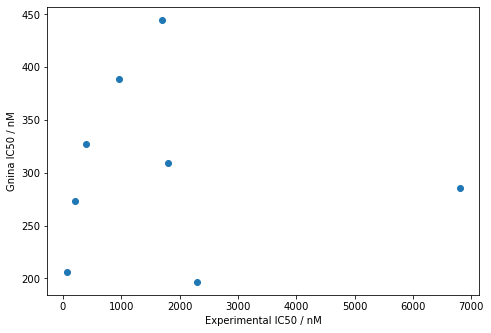

In [47]:
import matplotlib.pyplot as plt
import numpy as np
#ligands 27 & 28 have stereochem issues
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(filtered_experimental, lowest) #, color='black', marker='x')
ax.set_xlabel('Experimental IC50 / nM')
ax.set_ylabel('Gnina IC50 / nM')

x = np.linspace(0,25,25)
y = np.linspace(50,350,25)
#ax.plot(x, y, color='black', linestyle='--')

plt.savefig('out.png', bbox_inches='tight')
plt.show()

In [ ]:
CNNscores

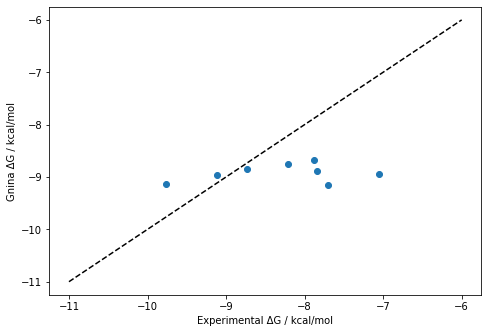

In [48]:
# convert nM to M
lowestinM = [ i * 1e-9 for i in lowest]
exptinM = [ i * 1e-9 for i in filtered_experimental]

RT = 0.593 # kcal/mol

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])

# DG = RTln(K)
ax.scatter(RT*np.log(exptinM), RT*np.log(lowestinM)) #, color='black', marker='x')
ax.set_xlabel('Experimental \u0394G / kcal/mol')
ax.set_ylabel('Gnina \u0394G / kcal/mol')

x = np.linspace(-11,-6,25)
ax.plot(x, x, color='black', linestyle='--')
A = np.vstack([filtered_experimental, np.ones(len(filtered_experimental))]).T
m, c = np.linalg.lstsq(A, lowest, rcond=None)[0]

m = "{:.2f}".format(m)
r = "r^2 =" + str(m)
#plt.annotate(r, (-10,-6))
plt.savefig('deltaG2_cdk2_noflex.png', bbox_inches='tight')
plt.show()

In [49]:
dG_xpt = RT*np.log(exptinM) #experimental scores in M
dG_gnina = RT*np.log(lowestinM) #gnina scores in M
rmse = np.sqrt(np.mean(np.square(dG_xpt - dG_gnina)))
rmse

1.0081214184398564

In [50]:
r = np.corrcoef(dG_xpt, dG_gnina)
r**2

array([[1.        , 0.07706176],
       [0.07706176, 1.        ]])

In [51]:
with open('CNNscores.dat', 'w') as f:
    for i in range(len(CNNscores)):
        f.write(str(CNNscores[i][0])+  '\n')